
# Cuaderno 2: Entrenamiento del Modelo Baseline (Random Forest)
**Objetivo:** Utilizar las características extraídas en la fase de EDA para entrenar un modelo de Machine Learning clásico (Random Forest) y establecer un rendimiento de referencia para el proyecto.


In [2]:
# Importaciones y Configuración
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
import sys
import joblib  # Para guardar el modelo
from tqdm import tqdm


In [3]:
# Importaciones de Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

# Añadir src al path para poder importar nuestros módulos
# Esto asume que el notebook está en `proyecto_cero/notebooks`
sys.path.append('../src')
from data_loader import build_metadata_df, load_audio_segment, bandpass_filter, normalize_signal
from feature_extractor import extract_mfcc, extract_zcr, extract_rms_energy

# --- Configuración ---
sns.set_theme(style="whitegrid")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

RANDOM_SEED = 42
# Asume que los datos ya están descargados en la ruta por defecto de kagglehub
# Le preguntamos a kagglehub la ruta del dataset ya descargado
import kagglehub
dataset_path = kagglehub.dataset_download("vbookshelf/respiratory-sound-database")
DATASET_ROOT_PATH = Path(dataset_path)
MODEL_OUTPUT_PATH = Path("../models/")
MODEL_OUTPUT_PATH.mkdir(exist_ok=True)  # Crear la carpeta de modelos si no existe


## 1. Preparación del Dataset
El primer paso es construir nuestro dataset de modelado. Para ello:
1.  Cargamos los metadatos de todos los ciclos respiratorios usando nuestra función `build_metadata_df`.
2.  Iteramos sobre cada ciclo, cargamos el segmento de audio correspondiente, lo preprocesamos y extraemos sus características (MFCCs, ZCR, RMS).
3.  Almacenamos las características en una matriz `X` y las etiquetas de diagnóstico en un vector `y`.


In [4]:
metadata_df = build_metadata_df(DATASET_ROOT_PATH)

features_list = []
labels_list = []

# Usamos tqdm para ver el progreso
for index, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0], desc="Procesando archivos"):
    try:
        # Cargar el segmento de audio
        signal, sr = load_audio_segment(row['audio_path'], row['start_time'], row['end_time'])
        
        # Pre-procesamiento
        signal_filtered = bandpass_filter(signal, sr, lowcut=100, highcut=2000)
        signal_norm = normalize_signal(signal_filtered)
        
        # Extracción de características
        mfcc = extract_mfcc(signal_norm, sr)
        zcr = extract_zcr(signal_norm, sr)
        rms = extract_rms_energy(signal_norm, sr)
        
        # Combinar todas las características en un solo vector
        combined_features = np.hstack([mfcc, zcr, rms])
        
        features_list.append(combined_features)
        labels_list.append(row['diagnosis'])
        
    except Exception as e:
        logger.error(f"Error procesando el archivo {row['audio_filename']} en el índice {index}: {e}")

# Convertir las listas a arrays de NumPy
X = np.array(features_list)
y_raw = np.array(labels_list)

# Codificar las etiquetas de texto a números (ej. 'Healthy' -> 0, 'COPD' -> 1)
le = LabelEncoder()
y = le.fit_transform(y_raw)

logger.info(f"Dataset creado. Forma de X: {X.shape}, Forma de y: {y.shape}")
logger.info(f"Clases codificadas: {list(le.classes_)} -> {le.transform(le.classes_)}")
logger.info(f"Número de muestras por clase: {pd.Series(y_raw).value_counts().to_dict()}")


2025-07-23 20:33:44,956 - INFO - Construyendo DataFrame de metadatos desde la estructura de archivos...
2025-07-23 20:33:47,616 - INFO - DataFrame construido con 6898 ciclos respiratorios.
Procesando archivos:   6%|▌         | 391/6898 [00:10<01:23, 78.30it/s]d:\Proyectos\proyecto_cero\venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1847
  warnings.warn(
Procesando archivos: 100%|██████████| 6898/6898 [03:06<00:00, 36.96it/s] 
2025-07-23 20:36:54,267 - INFO - Dataset creado. Forma de X: (6898, 15), Forma de y: (6898,)
2025-07-23 20:36:54,269 - INFO - Clases codificadas: [np.str_('Asthma'), np.str_('Bronchiectasis'), np.str_('Bronchiolitis'), np.str_('COPD'), np.str_('Healthy'), np.str_('LRTI'), np.str_('Pneumonia'), np.str_('URTI')] -> [0 1 2 3 4 5 6 7]
2025-07-23 20:36:54,651 - INFO - Número de muestras por clase: {'COPD': 5746, 'Healthy': 322, 'Pneumonia': 285, 'URTI': 243, 'Bronchiolitis': 160, 'Bronchiectasis': 10

## 2. División de Datos y Entrenamiento del Modelo

Dividimos los datos en un conjunto de **entrenamiento (80%)** y uno de **prueba (20%)**.
* **`stratify=y`**: Asegura que la proporción de clases (ej. 70% sanos, 30% EPOC) sea la misma en ambos conjuntos. Esto es crucial para datasets desbalanceados.
* **`random_state=42`**: Garantiza que la división sea siempre la misma, haciendo nuestros resultados reproducibles.

Luego, entrenamos un clasificador **Random Forest**.
* **`class_weight='balanced'`**: Parámetro muy importante que ajusta el modelo para que preste más atención a las clases minoritarias, combatiendo el desbalance.


In [5]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

logger.info(f"Datos divididos. Entrenamiento: {X_train.shape[0]} muestras, Prueba: {X_test.shape[0]} muestras.")

# Creación y entrenamiento del modelo
model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, class_weight='balanced', n_jobs=-1)

logger.info("Entrenando el modelo Random Forest...")
model.fit(X_train, y_train)
logger.info("Entrenamiento completado.")


2025-07-23 20:36:54,676 - INFO - Datos divididos. Entrenamiento: 5518 muestras, Prueba: 1380 muestras.
2025-07-23 20:36:54,677 - INFO - Entrenando el modelo Random Forest...
2025-07-23 20:36:55,290 - INFO - Entrenamiento completado.


## 3. Evaluación del Rendimiento

Ahora vemos qué tan bien funciona nuestro modelo en los datos que nunca ha visto (el conjunto de prueba).
* **Reporte de Clasificación**: Nos da métricas clave como `Precision`, `Recall` y `F1-score` para cada clase.
* **Matriz de Confusión**: Nos muestra visualmente en qué se está equivocando el modelo. Por ejemplo, cuántos pacientes sanos clasificó como EPOC (Falsos Positivos) y viceversa (Falsos Negativos).


d:\Proyectos\proyecto_cero\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Proyectos\proyecto_cero\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Proyectos\proyecto_cero\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


--- Reporte de Clasificación ---
                precision    recall  f1-score   support

        Asthma       0.00      0.00      0.00         1
Bronchiectasis       0.93      0.67      0.78        21
 Bronchiolitis       1.00      0.34      0.51        32
          COPD       0.90      1.00      0.95      1150
       Healthy       0.88      0.36      0.51        64
          LRTI       0.50      0.17      0.25         6
     Pneumonia       0.96      0.44      0.60        57
          URTI       0.97      0.59      0.73        49

      accuracy                           0.91      1380
     macro avg       0.77      0.45      0.54      1380
  weighted avg       0.91      0.91      0.89      1380


--- Matriz de Confusión ---


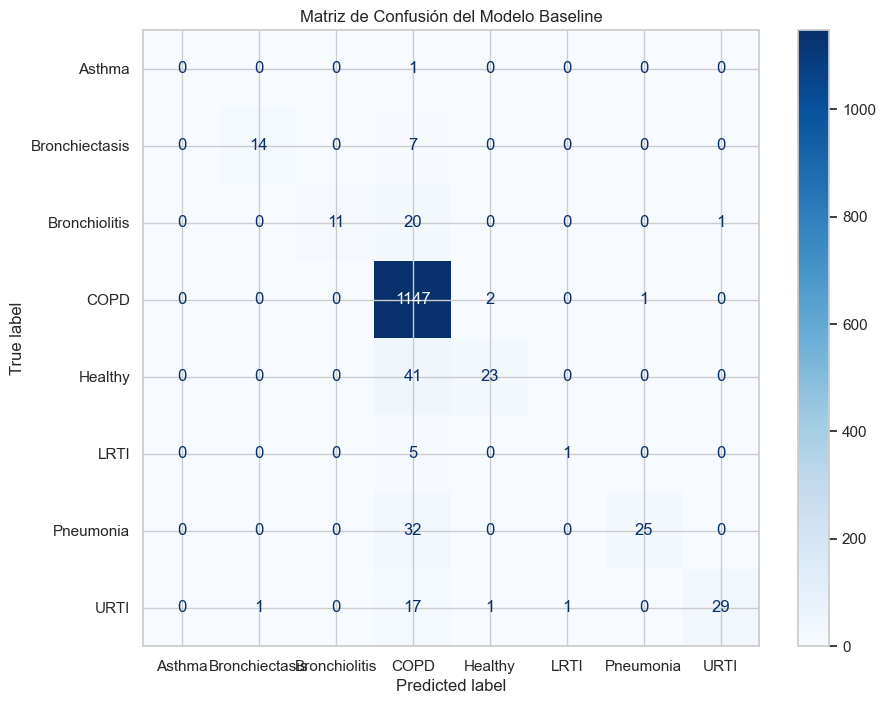

In [6]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Reporte de Clasificación (Precision, Recall, F1-Score)
print("--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de Confusión
print("\n--- Matriz de Confusión ---")
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=le.classes_, cmap='Blues', ax=ax)
plt.title("Matriz de Confusión del Modelo Baseline")
plt.show()

## 4. Análisis de Importancia de Características

Una gran ventaja del Random Forest es que podemos preguntarle qué características fueron las más importantes para tomar sus decisiones. Esto nos da pistas sobre qué señales acústicas son más relevantes para diferenciar entre las distintas condiciones respiratorias.


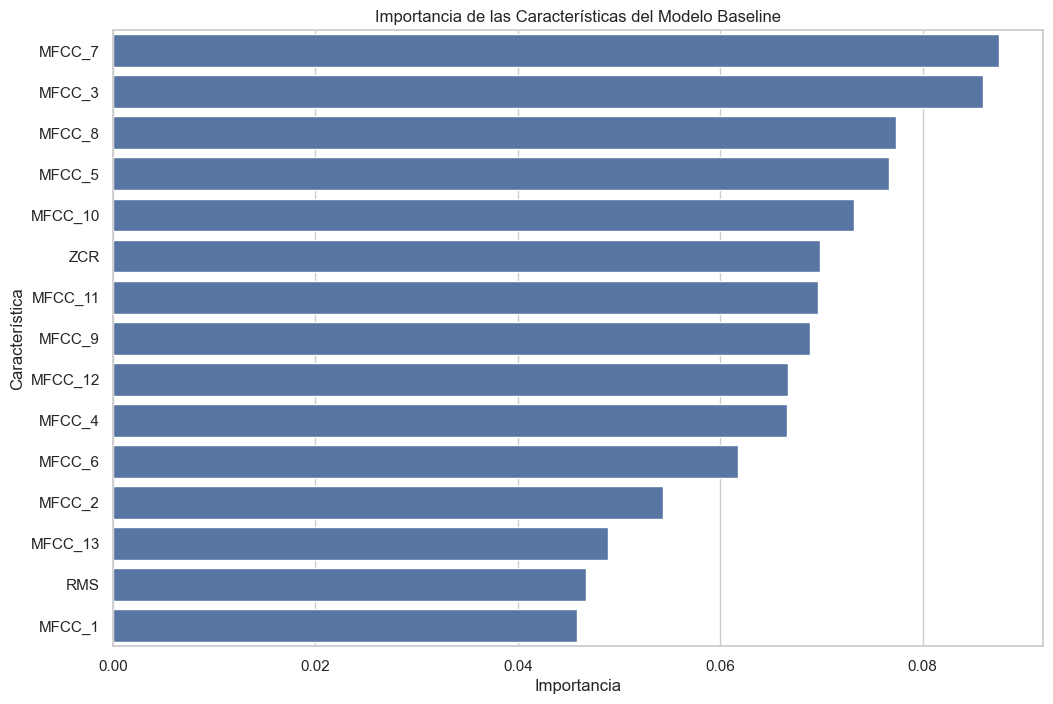

In [7]:
# Crear nombres para las características para que el gráfico sea legible
n_mfcc = 13  # El número de MFCCs que extrajimos
feature_names = [f'MFCC_{i+1}' for i in range(n_mfcc)] + ['ZCR', 'RMS']

# Obtener importancias y crear un DataFrame de pandas
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Graficar
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Importancia de las Características del Modelo Baseline')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()

## 5. Guardar el Modelo

Finalmente, guardamos el modelo entrenado (`model`) y el codificador de etiquetas (`le`) en archivos. Esto se conoce como **serialización** o **persistencia** del modelo.

Nos permite cargar estos "artefactos" más tarde para hacer nuevas predicciones sin tener que re-entrenar todo el pipeline, lo cual es esencial para poner un modelo en producción.


In [8]:
# Guardar el modelo
model_filename = "respiratory_sound_baseline_rf.joblib"
joblib.dump(model, MODEL_OUTPUT_PATH / model_filename)

# Guardar el codificador de etiquetas
encoder_filename = "label_encoder.joblib"
joblib.dump(le, MODEL_OUTPUT_PATH / encoder_filename)

logger.info(f"Modelo guardado en: {MODEL_OUTPUT_PATH / model_filename}")
logger.info(f"Codificador de etiquetas guardado en: {MODEL_OUTPUT_PATH / encoder_filename}")

2025-07-23 20:36:56,381 - INFO - Modelo guardado en: ..\models\respiratory_sound_baseline_rf.joblib
2025-07-23 20:36:56,383 - INFO - Codificador de etiquetas guardado en: ..\models\label_encoder.joblib


## Análisis de Resultados del Modelo Baseline (Random Forest)

Se ha entrenado un modelo `RandomForestClassifier` como línea base para la clasificación de sonidos respiratorios. 

### 1. Evaluación Cuantitativa (Classification Report)

#### Métricas Globales
A nivel global, el modelo exhibe un rendimiento superficialmente alto, con una **exactitud (accuracy) general del 91%** y un **F1-score ponderado de 0.89**. Si bien estas cifras son alentadoras, un análisis más profundo revela que están infladas por el fuerte desbalance de clases presente en el dataset.

#### Análisis por Clase
El rendimiento varía drásticamente entre las distintas clases:
* **Clase Mayoritaria (`COPD`):** El modelo logra un rendimiento casi perfecto en la detección de EPOC, con un **F1-score de 0.95** y un **`recall` de 1.00**. Esto indica que el modelo es capaz de identificar prácticamente todos los casos de EPOC presentes en el conjunto de prueba.
* **Clases Minoritarias:** El rendimiento decae de forma alarmante en las clases con menor número de muestras. El **`recall` es particularmente bajo** para clases clave como `Healthy` (0.36), `Bronchiolitis` (0.34) y `Pneumonia` (0.44). Esto implica que el modelo falla en detectar más de la mitad de los casos de estas condiciones, lo cual es inaceptable para una aplicación médica.
* **Clases Nulas:** La clase `Asthma`, con una sola muestra en el conjunto de prueba, obtiene un F1-score de 0.00, evidenciando la incapacidad del modelo para aprender de datos extremadamente escasos.

### 2. Interpretación de la Matriz de Confusión: El Problema del Sesgo

La matriz de confusión confirma visualmente el diagnóstico del reporte de clasificación. Se observa una **fuerte polarización de las predicciones hacia la clase `COPD`**. La columna vertical bajo la etiqueta "Predicted: COPD" acumula un número muy elevado de errores (Falsos Positivos para la clase COPD), donde muestras de casi todas las demás patologías son incorrectamente clasificadas como EPOC.

Este comportamiento es un síntoma clásico de un modelo que, para minimizar su error global en un dataset desbalanceado, aprende a "apostar" por la clase más frecuente.

### 3. Insights de Importancia de Características

El análisis de `feature_importances_` del Random Forest es valioso. Revela que los **Coeficientes Cepstrales en la Frecuencia de Mel (MFCCs)**, particularmente los coeficientes 3, 5, 7 y 8, son los predictores más influyentes. La **Tasa de Cruce por Cero (ZCR)** también figura con una alta importancia.

**Conclusión de Características:** Esto valida nuestra hipótesis de que el timbre y la textura espectral del sonido contienen la información más relevante. Sin embargo, estas características por sí solas no son suficientes para que el modelo actual distinga las clases minoritarias con precisión.

### 4. Conclusiones Estratégicas y Próximos Pasos

* **Diagnóstico del Modelo:** El modelo baseline ha sido exitoso en establecer que **el problema es tratable** y que las características de audio contienen una señal predictiva. Sin embargo, sufre de un **sesgo severo hacia la clase mayoritaria** y su rendimiento en las clases minoritarias es insuficiente para cualquier aplicación práctica.

* **Recomendaciones y Estrategia Futura:**
    1.  **Mitigación del Desbalance:** Para mejorar modelos de ML clásicos, sería necesario implementar técnicas de remuestreo avanzadas como **SMOTE** (para generar muestras sintéticas de clases minoritarias) o un **submuestreo (undersampling) inteligente** de la clase `COPD`.
    2.  **Transición a Modelos de Mayor Capacidad (Deep Learning):** El bajo rendimiento en la diferenciación de clases, a pesar de tener características relevantes, sugiere que las relaciones son demasiado complejas para el Random Forest. Este es el momento ideal para proceder a la **Fase 3: Desarrollo de un Modelo de Deep Learning (1D-CNN)**. Se hipotetiza que una red neuronal convolucional, al aprender características jerárquicas directamente desde la señal de audio cruda, podrá capturar los patrones sutiles que el modelo actual no puede, permitiendo una mejor separación entre las patologías.

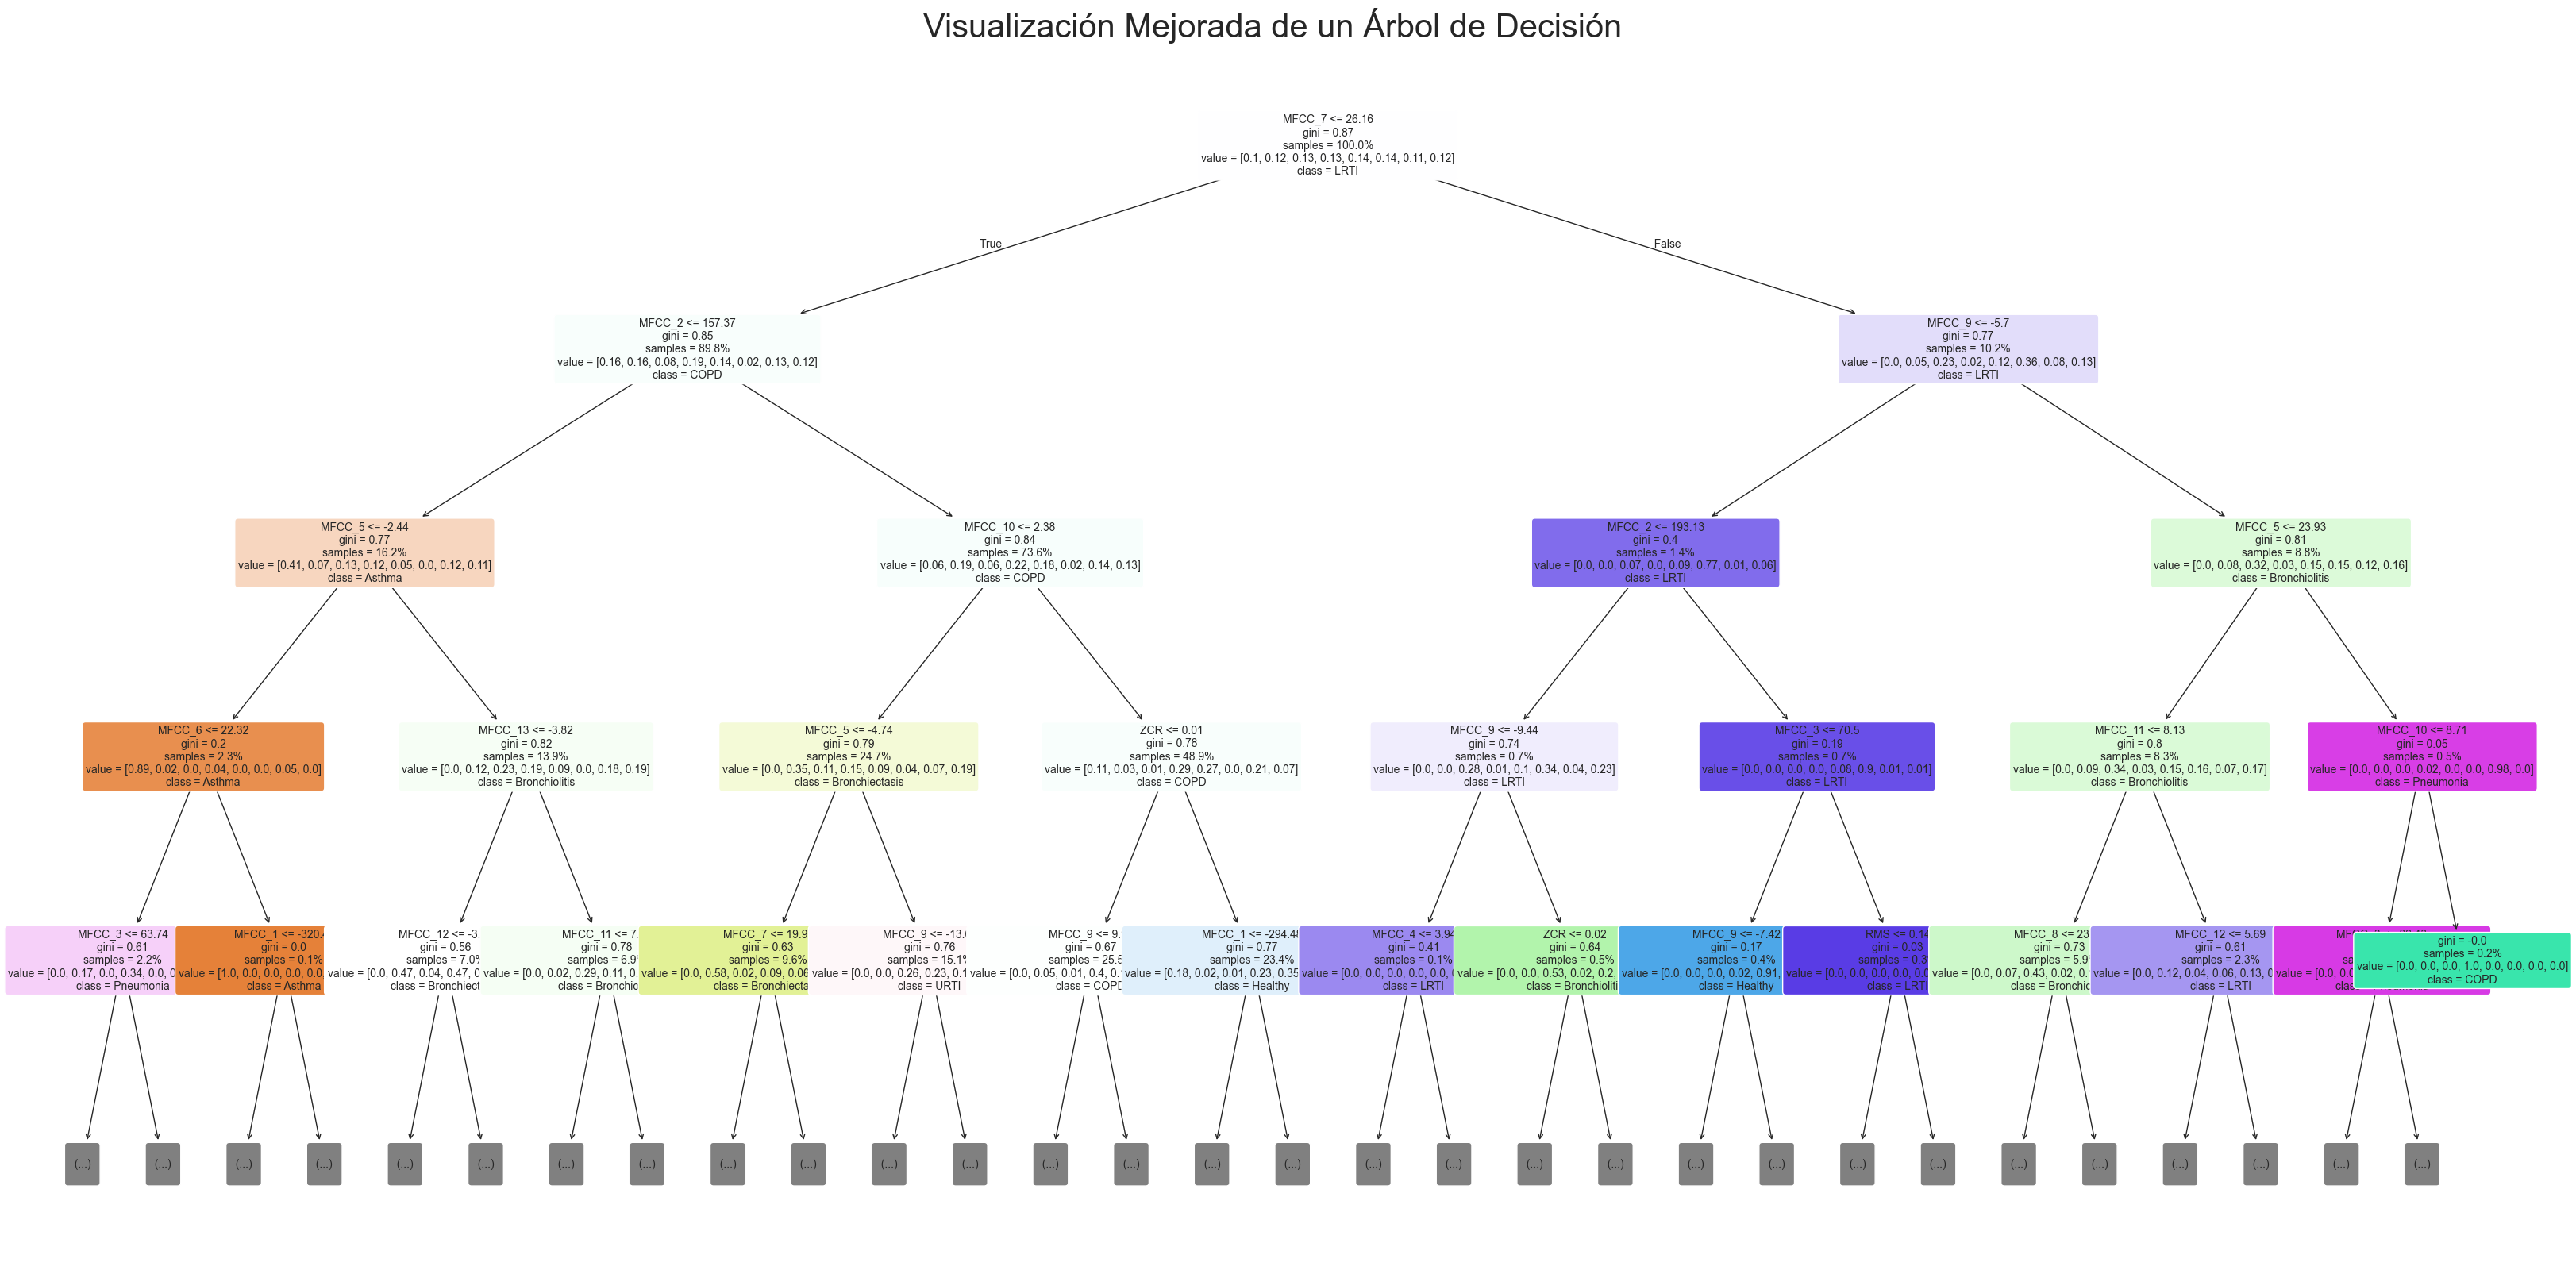

In [10]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Asumiendo que tu modelo entrenado se llama 'model', 
# los nombres de las características 'feature_names', 
# y tu LabelEncoder 'le' ya existen en la memoria del notebook.

# --- MEJORAS CLAVE ---

# 1. Aumentar drásticamente el tamaño de la figura (ancho, alto en pulgadas)
#    Le damos al gráfico mucho más espacio para que los nodos no se superpongan.
plt.figure(figsize=(40, 20))

# 2. Llamar a plot_tree con parámetros de legibilidad
plot_tree(
    model.estimators_[0],           # Seleccionamos el primer árbol del bosque
    feature_names=feature_names,
    class_names=le.classes_,
    filled=True,
    rounded=True,
    max_depth=4,                    # <-- Reducimos la profundidad a 4 para un análisis inicial más claro
    fontsize=10,                    # <-- Reducimos un poco el tamaño de la fuente
    proportion=True,                # <-- Muestra porcentajes en lugar de cuentas de muestras, más limpio
    precision=2                     # <-- Limita los decimales en los valores de Gini, etc.
)

# 3. Guardar con alta resolución (dpi) para poder hacer zoom después
plt.title("Visualización Mejorada de un Árbol de Decisión", fontsize=30)
plt.savefig("random_forest_tree_mejorado.png", dpi=300)
plt.show()